In [2]:
# Install dependencies (if not already)
!pip install datasets

import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Load dataset
dataset = load_dataset("Pablinho/movies-dataset")
df = pd.DataFrame(dataset["train"])
df.head()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

9000plus.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/9837 [00:00<?, ? examples/s]

,Release_Date,Title,Overview,Popularity,Vote_Count,Vote_Average,Original_Language,Genre,Poster_Url
0,2021-12-15,Spider-Man: No Way Home,Peter Parker is unmasked and no longer able to...,5083.954,8940,8.3,en,"Action, Adventure, Science Fiction",https://image.tmdb.org/t/p/original/1g0dhYtq4i...
1,2022-03-01,The Batman,"In his second year of fighting crime, Batman u...",3827.658,1151,8.1,en,"Crime, Mystery, Thriller",https://image.tmdb.org/t/p/original/74xTEgt7R3...
2,2022-02-25,No Exit,Stranded at a rest stop in the mountains durin...,2618.087,122,6.3,en,Thriller,https://image.tmdb.org/t/p/original/vDHsLnOWKl...
3,2021-11-24,Encanto,"The tale of an extraordinary family, the Madri...",2402.201,5076,7.7,en,"Animation, Comedy, Family, Fantasy",https://image.tmdb.org/t/p/original/4j0PNHkMr5...
4,2021-12-22,The King's Man,As a collection of history's worst tyrants and...,1895.511,1793,7.0,en,"Action, Adventure, Thriller, War",https://image.tmdb.org/t/p/original/aq4Pwv5Xeu...


In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


df['Vote_Count'] = pd.to_numeric(df['Vote_Count'], errors='coerce').fillna(0)
df['Vote_Average'] = pd.to_numeric(df['Vote_Average'], errors='coerce').fillna(0)

#Handle the multi-label 'Genre' column correctly
genre_dummies = df['Genre'].str.strip('[]').str.get_dummies(sep=', ')

#Handle the numerical feature ('Vote_Count') and scale it
scaler = StandardScaler()
vote_count_scaled = scaler.fit_transform(df[['Vote_Count']])
vote_count_df = pd.DataFrame(vote_count_scaled, columns=['Vote_Count_Scaled'], index=df.index)

#Combine the processed features into a final feature matrix 'X'
X = pd.concat([genre_dummies, vote_count_df], axis=1)

#Prepare the target variable (already cleaned in step 1)
y_ratings = df['Vote_Average']

print("### Final Feature Matrix (X) ###")
print("Shape:", X.shape)
print("\nFirst 5 rows:")
print(X.head())

### Final Feature Matrix (X) ###
Shape: (9837, 20)

First 5 rows:
   Action  Adventure  Animation  Comedy  Crime  Documentary  Drama  Family  \
0       1          1          0       0      0            0      0       0   
1       0          0          0       0      1            0      0       0   
2       0          0          0       0      0            0      0       0   
3       0          0          1       1      0            0      0       1   
4       1          1          0       0      0            0      0       0   

   Fantasy  History  Horror  Music  Mystery  Romance  Science Fiction  \
0        0        0       0      0        0        0                1   
1        0        0       0      0        1        0                0   
2        0        0       0      0        0        0                0   
3        1        0       0      0        0        0                0   
4        0        0       0      0        0        0                0   

   TV Movie  Thriller  War

In [5]:
# Reduce to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.3311851  0.12296767]


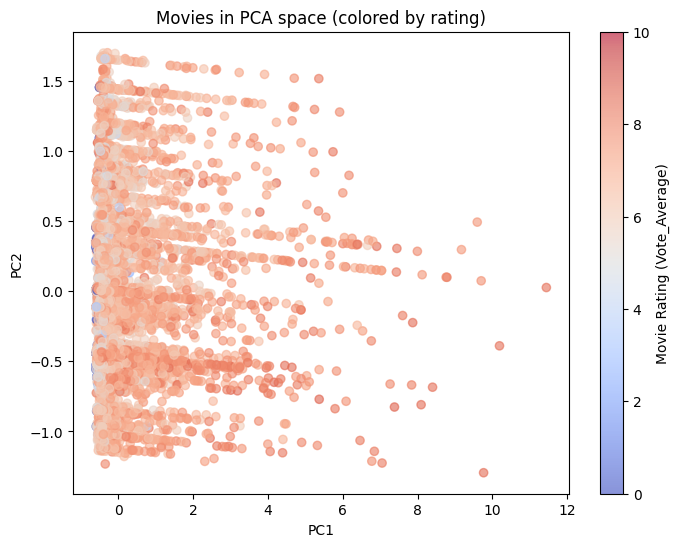

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1],
            c=y_ratings, cmap="coolwarm", alpha=0.6)
plt.colorbar(label="Movie Rating (Vote_Average)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Movies in PCA space (colored by rating)")
plt.show()


In [8]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_ratings, test_size=0.2, random_state=42
)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MSE: 1.2446340734235346
R²: 0.06387962578106798


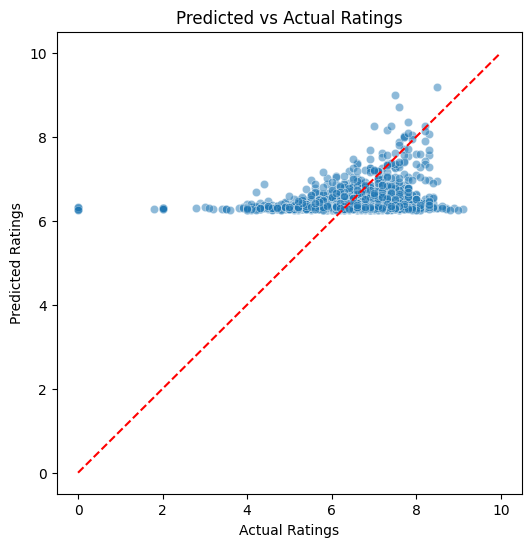

In [9]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([0,10], [0,10], color="red", linestyle="--")  # line y=x
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Predicted vs Actual Ratings")
plt.show()
